# Negative Binomial Regression

Negative binomial regression can be used for over-dispersed count data, that is when the conditional variance exceeds the conditional mean.

Negative binomial regression is used to test for associations between predictor and confounding variables on a count outcome variable when the variance of the count is higher than the mean of the count.

In [3]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

In [5]:
#add a few derived regression variables to the X matrix
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [6]:
#create the training and testing data sets
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=172
Testing data set length=42


In [9]:
#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

In [10]:
#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [11]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(
    y_train, X_train, family=sm.families.Poisson()).fit()

In [12]:
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      165
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12857.
Date:                Fri, 08 Jul 2022   Deviance:                       24055.
Time:                        21:32:32   Pearson chi2:                 2.41e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.9971      0.013    559.292      0.000       6.973       7.022
DAY             0.0003      0.000      1.598      0.110   -6.11e-05       0.001
DAY_OF_WEEK    -0.0219      0.001    -29.344      0.000      -0.023      -0.020
MONTH           0.0150      0.001     19.522      0.000       0.014       0.017
HIGH_T          0.0236      0.000     70.149      0.000       0.023       0.024
LOW_T          -0.0135      0.000    -36.822      0.000      -0.014      -0.013
PRECIP         -0.8375      0.008   -101.903      0.000      -0.854      -0.821
===============================================================================
"""

In [13]:
poisson_training_results.mu

array([1872.07375103, 2537.69186347, 2554.15199365,  760.52269813,
       2647.13590316, 1078.23955859, 1837.7902902 , 2278.12037074,
       2641.28993459, 3265.76453359, 2873.33161285, 2554.68338425,
       2397.91208265, 3255.31916715, 2761.45849819, 2060.50119394,
       2235.00333097, 1538.5007413 , 1772.04814224, 2518.16237495,
       2439.39020514,  972.94796403, 3055.66810967, 2244.82405991,
       3285.65793188, 2678.58996168, 2393.12626225, 2490.61263481,
       1900.12934648, 2472.03597001, 2553.28748081, 2323.38763624,
       2355.57291733,  644.55687322, 2538.31621296, 2701.11530355,
       3350.96018551, 3893.18952578, 3529.96374231, 3263.38945092,
       2401.65578822, 1473.86801157, 2469.56116134, 1262.10340038,
       2635.92667679, 2517.44659766, 2094.46730452, 3064.72239076,
       2773.469752  , 2156.58842462, 2541.41200078, 2686.84979088,
       2522.88779612, 3284.22094926, 3121.61371692, 3718.80495233,
       2578.92989426, 2713.22216667, 2251.20880953, 1180.25901

In [15]:
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['BB_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()


C:\Users\User\AppData\Local\Temp\ipykernel_8860\1426478729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BB_LAMBDA'] = poisson_training_results.mu
C:\Users\User\AppData\Local\Temp\ipykernel_8860\1426478729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)


In [16]:
aux_olsr_results.params

BB_LAMBDA    0.040415
dtype: float64

In [17]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(
    alpha=aux_olsr_results.params[0])).fit()

#print the training summary
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      165
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1390.6
Date:                Fri, 08 Jul 2022   Deviance:                       327.19
Time:                        21:34:04   Pearson chi2:                     306.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9070
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.6792      0.120     55.601      0.000       6.444       6.915
DAY            -0.0001      0.002     -0.069      0.945      -0.004       0.003
DAY_OF_WEEK    -0.0186      0.008     -2.407      0.016      -0.034      -0.003
MONTH           0.0165      0.008      2.072      0.038       0.001       0.032
HIGH_T          0.0300      0.003      8.722      0.000       0.023       0.037
LOW_T          -0.0164      0.004     -4.280      0.000      -0.024      -0.009
PRECIP         -0.7687      0.047    -16.468      0.000      -0.860      -0.677
===============================================================================
"""

In [18]:
#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
predictions_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2017-04-10,3169.121886,138.592062,2908.802204,3452.738560
2017-04-13,2460.165424,81.196736,2306.060823,2624.568205
2017-04-17,2711.477506,108.040632,2507.779293,2931.721418
2017-04-26,1525.361652,64.778041,1403.539258,1657.757811
2017-04-27,2347.003527,88.153823,2180.431654,2526.300491
2017-04-28,3668.095761,208.997177,3280.512787,4101.470528
2017-05-05,197.256989,26.507897,151.581349,256.695959
2017-05-06,1889.795288,68.341129,1760.485905,2028.602569
2017-05-10,2943.875098,103.250682,2748.306371,3153.360443


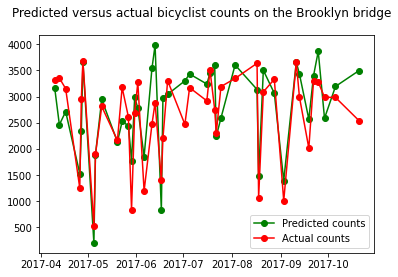

In [19]:
#plot the predicted counts versus the actual counts for the test data
predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts,
                      'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
